# Imports

In [15]:
import os, sys, pickle, itertools
from glob import glob
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, matthews_corrcoef
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain
import pandas as pd
import scikit_posthocs as sp
from scipy.stats import friedmanchisquare
sys.path.append(".")
sys.path.append("..")

# Variables

In [3]:
projects = [
'shardingsphere-elasticjob','janusgraph','light-4j','inav','swagger-core','flatpak','RxJava','pygame','realm-java','glide','lxc','SoftEtherVPN','iceberg','netty','InfiniTime','mpv',
'zaproxy','premake-core','open5gs','netdata','presto','graylog2-server','mockito','AdAway','dynamorio','XChange','WinObjC','Terasology',
'FreeRDP','gatk','checkstyle','grpc-java','radare2','collectd','Mekanism','shenyu','klipper','lvgl','sway','samtools','libevent','druid','zfs','phpredis','hashcat',
'betaflight','spock','i3','PocketHub','framework','Rajawali','maxwell','pinpoint','nodemcu-firmware','nng','MinecraftForge','baritone','cleanflight','redis','jabref'
]
perf_order = ['AUC', 'f1-macro', 'f1-micro', 'accuracy', 'precision-macro', 'precision-micro', 'recall-macro', 'recall-micro', 'MCC', 'normMCC']
classifier_order = ['DecisionTree', 'RandomForest', 'CatBoost', 'AdaBoost', 'XGB']
threshold_order = ['0.3_0.3_0.3', '0.4_0.4_0.4', '0.5_0.5_0.5', '0.6_0.6_0.6', '0.7_0.7_0.7']

# Calculate model performances (F1, recall, precision, mcc, etc.)

### compare AUC performance on different classifiers

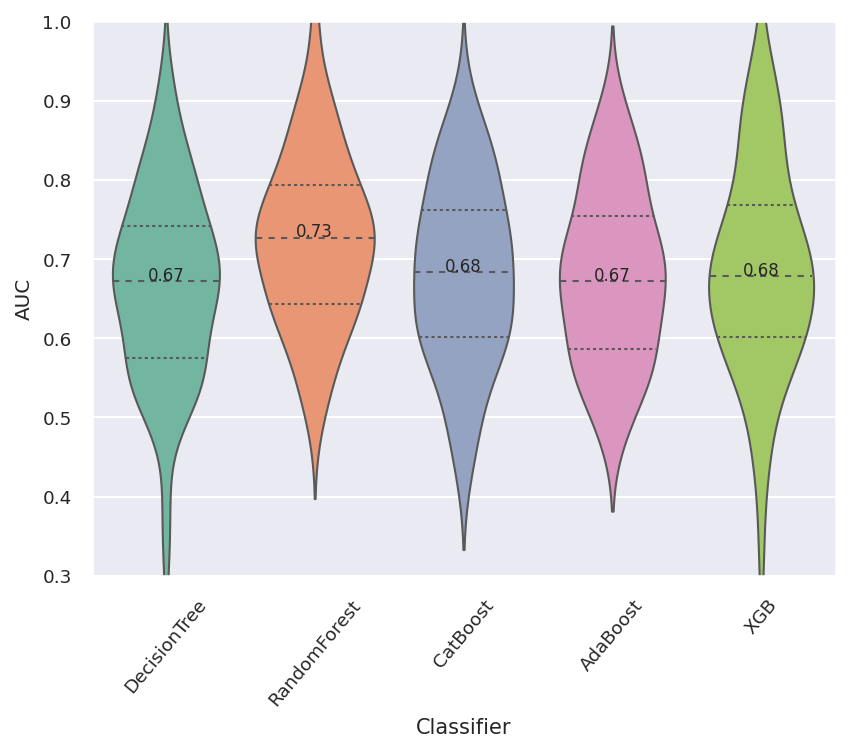

In [4]:
file_path = 'result_perf.csv'
# Read CSV file into a DataFrame
df = pd.read_csv(file_path)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 8.2))
plt.figure(dpi=150)
sns.set_style("whitegrid")
sns.set(font_scale = .8)
df['AUC_float'] = df['AUC'].astype(float)
ax = sns.violinplot(x='classifier',  y='AUC_float', data=df,
               linewidth=1.0, split=True, palette="Set2", inner="quartile",
               order=classifier_order
    ) # cut=0, kind='kde',
# Set y-axis label
ax.set_ylabel('AUC')
ax.set_xticklabels(ax.get_xticklabels(),rotation=50)
ax.set_xlabel('Classifier', fontsize=10)

for i in range(1, len(ax.lines), 3):
    line = ax.lines[i]
    ax.text(x = (line.get_data()[0][0] + line.get_data()[0][1])/2, #line.get_data()[0][l.get_data()[0].nonzero()][0], 
                  y = line.get_data()[1][0] * 1.01, 
                  s = f'{line.get_data()[1][0]:.2f}',
                  size='small', ha='center', va='center'
           )  
plt.ylim(0.3, 1.0)
ax.figure.savefig("RQ1-classifiers-AUC.png", dpi=300, bbox_inches="tight")

# Conduct threshold sensitivity analysis

### compare different threshold performance at AUC

/tmp/ipykernel_2929601/3837593537.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rf['AUC_float'] = df_rf['AUC'].astype(float)


(0.4, 1.0)

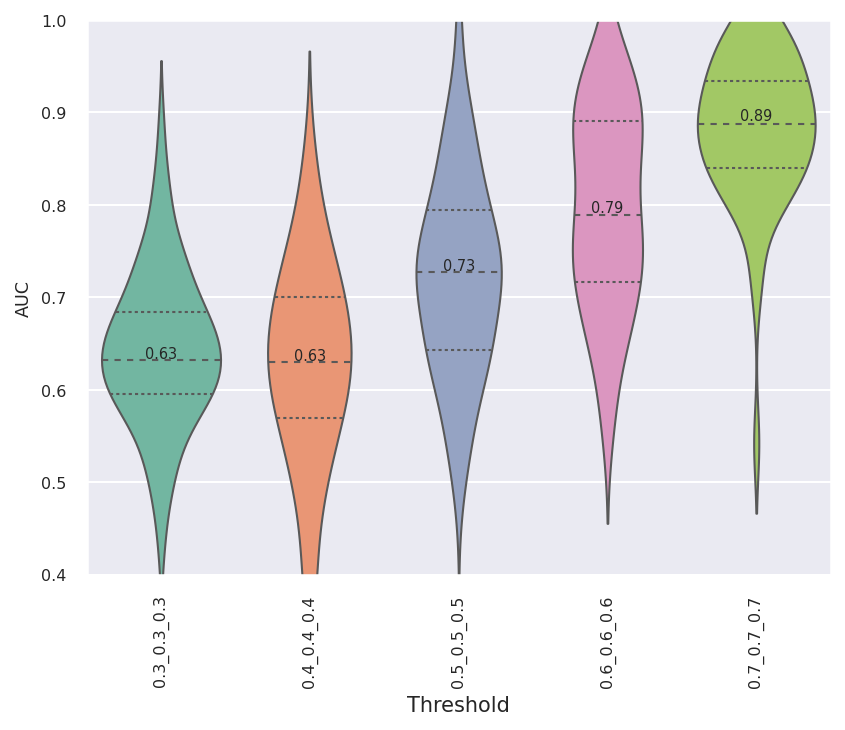

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set(font_scale=3)

plt.figure(dpi=150)
sns.set_style("whitegrid")
sns.set(font_scale = .7)
df_rf = df[df['classifier']=='RandomForest']

df_rf['AUC_float'] = df_rf['AUC'].astype(float)
ax = sns.violinplot(x='threshold',  y='AUC_float', data=df_rf, 
               linewidth=1.0, split=True, palette="Set2", inner="quartile",
               order=threshold_order
    )
# Set y-axis label
ax.set_ylabel('AUC')
# plt.ylim(None,1)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_xlabel('Threshold', fontsize=10)
for i in range(1, len(ax.lines), 3):
    line = ax.lines[i]
    ax.text(x = (line.get_data()[0][0] + line.get_data()[0][1])/2, #line.get_data()[0][l.get_data()[0].nonzero()][0], 
                  y = line.get_data()[1][0] * 1.01, 
                  s = f'{line.get_data()[1][0]:.2f}',
                  size='small', ha='center', va='center'
           ) 
plt.ylim(0.4, 1.0)


### check the average group by MCC

In [20]:
columns = ['AUC', 'micro-precision', 'micro-recall','MCC']
df[columns] = df[columns].astype(float)
average_df = df.groupby('threshold')[columns].mean().reset_index()

# Now average_df contains the average of all numeric columns for each threshold
display(average_df)

,threshold,AUC,micro-precision,micro-recall,MCC
0,0.3_0.3_0.3,0.645048,0.645048,0.645048,0.235964
1,0.4_0.4_0.4,0.621792,0.621792,0.621792,0.223329
2,0.5_0.5_0.5,0.687670,0.687670,0.687670,0.248920
3,0.6_0.6_0.6,0.794866,0.794866,0.794866,0.250069
4,0.7_0.7_0.7,0.880888,0.880888,0.880888,0.211093


### check the threshold groups using Friedman test statistic, followed by Nemenyi’s post-hoc test 

In [21]:

# Pivot the DataFrame to prepare for Friedman test
df_rf_pivoted = df_rf.pivot(index='project', columns='threshold', values='AUC_float')

# Fill missing values
df_rf_pivoted.fillna(0.5, inplace=True)

# Perform the Friedman test
stat, p = friedmanchisquare(*[df_rf_pivoted[col] for col in df_rf_pivoted])

print(f"Friedman test statistic: {stat}")
print(f"P-value: {p}")

# Interpretation
alpha = 0.05
if p > alpha:
    print("Same distribution (fail to reject H0)\n")
else:
    print(f"=> Different distributions (reject H0) at alpha {alpha}\n ")

# Perform Nemenyi's post-hoc test
nemenyi_results = pd.DataFrame(sp.posthoc_nemenyi_friedman(df_rf_pivoted))
nemenyi_results.style.applymap(lambda x: "font-weight: bold" if isinstance(x, float) and x >= 0.01 else '')

print("Nemenyi's post-hoc test results:")
display(nemenyi_results)


Friedman test statistic: 118.169779286927
P-value: 1.3137832841103664e-24
=> Different distributions (reject H0) at alpha 0.05
 
Nemenyi's post-hoc test results:


/tmp/ipykernel_2929601/900968655.py:22: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  nemenyi_results.style.applymap(lambda x: "font-weight: bold" if isinstance(x, float) and x >= 0.01 else '')


,0.3_0.3_0.3,0.4_0.4_0.4,0.5_0.5_0.5,0.6_0.6_0.6,0.7_0.7_0.7
0.3_0.3_0.3,1.000000,0.900,0.001641,0.001000,0.001000
0.4_0.4_0.4,0.900000,1.000,0.001000,0.001000,0.001000
0.5_0.5_0.5,0.001641,0.001,1.000000,0.034648,0.001000
0.6_0.6_0.6,0.001000,0.001,0.034648,1.000000,0.815558
0.7_0.7_0.7,0.001000,0.001,0.001000,0.815558,1.000000
